# Projeto

O Projeto é uma solução de dados de com a necessidade de integrar os dados de duas fontes diferentes (RDBMS e um Data Lake)



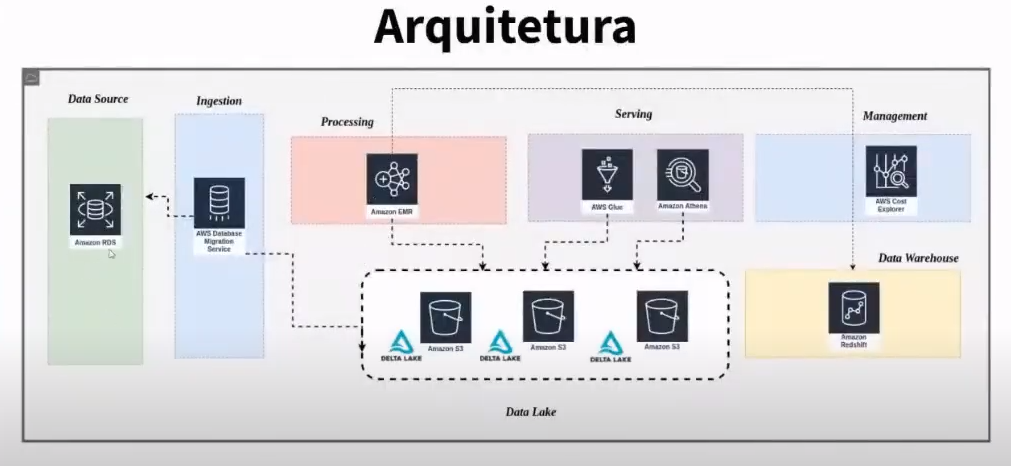

## Operações do projeto

* Aplicação para escrever dados em Banco de Dados Relacional na AWS
* Aplicação para escrever JSON no Data Lake da AWS (persistir dados de uma API na AWS)

## CAMADAS

### Camada: Data Sources


Para preparar o ambiente em CLOUD (construção de Banco de Dados Relacional e um Data Lake usando S3) são usadas duas estratégias diferentes. Uma delas é conectando ao Banco de Dados PostgreSQL usando o `psycopg2` e a outra é usando o SKD da AWS chamada `boto3`, que acessa a um recurso da AWS através das chaves de acesso.



### Camada: ingestão

A camada de ingestão faz a transferência dos dados o BD para o Data Lake, utilizando um serviço próprio da AWS.

* Como fazer ingestão?
* Quais são os tipos de ingestão?

# Solução

## Banco de Dados & Python

`psycopg2` é um adaptador de banco de dados PostgreSQL (database driver) para a linguagem de programação Python, ou seja, ele faz a ponte entre uma linguagem de programação e um Sistema de Gerenciamento de Banco de Dados (RDBMS). Ele permite ter vários _threads_ compartilhando a mesma conexão. Ele permite a criação de cursores para o _client-side_ e para o _server-side_, comunicação e notificação assíncrona e suporta `COPY TO/COPY FROM`

* The binary package is a practical choice for development and testing but in production it is advised to use the package built from sources. A stand-alone package, not requiring a compiler or external libraries, by installing the psycopg2-binary package from PyPI.

```python
pip install psycopg2-binary
```

```python
pip install psycopg2
```

**ORM**

Um ORM é uma ferramenta que gera scripts SQL (_SQL statements_). Já um _database driver_ envia o script SQL para o Banco de Dados. Então ORM são uma estratégia para abstrair a conexão com os Bancos de Dados e ser uma solução mais alto-nível, trazendo maior facilidade no desenvolvimento, mas menos capacidade de customização. Ele abstrai as especificidades de cada banco de dados, trazendo maior independência ao desenvolvimento do sistema de banco de banco de dados escolhido.

## Solução de Banco de Dados Relacional

Como subir um Banco de Dados Relacional na Cloud (AWS RDS)? Como subir uma infraestrutura de uma aplicação?

Por que um RDB? É muito comum existir sistemas que são estruturados em Bancos de Dados Relacionais.

O Amazon RDS é uma solução:
    * escalável,
    * fácil de configurar,
    * confiável,
    * gestão simples (pois ele já automatiza diversas tarefas de um DBA)
        * Banco de Dados automatizado
        * Auta disponibilidade
        * Segurança configurada

In [ ]:
import psycopg2
import os
from dotenv import load_dotenv

import random
from faker import Faker  # serve para criar dados fictícios


def create_tables(cursor, tables_scripts: dict) -> int:
    """ Cria tabelas de um dicionário de scripts SQL no Banco de Dados.
    ------
    PARAMS
        cursor: cursor do banco de dados
        tables_scripts: dicionário de scripts SQL para criar as tabelas
    ------
    RETURN
        int: 0 para sucesso, 1 para falha
    """
    for table_script in tables_scripts:
        try:
            cursor.execute(table_script)
        except psycopg2.Error as e:
            print('Erro ao criar a tabela:', e)
            return 1

    # Mensagem de conclusão
    print("Tabelas criadas com sucesso no Banco de Dados!")

    return 0


def get_create_tables_scripts() -> dict:
    """ Retorna um dicionário de scripts SQL para criar as tabelas Customers, Products e Orders.
    RETURN
        dict: dicionário de scripts SQL
    """

    customers_sql = """
        CREATE TABLE IF NOT EXISTS Customers (
            id SERIAL PRIMARY KEY,
            name VARCHAR(255) NOT NULL,
            email VARCHAR(255) NOT NULL
        )
        """

    products_sql = """
        CREATE TABLE IF NOT EXISTS Products (
            id SERIAL PRIMARY KEY,
            name VARCHAR(255) NOT NULL,
            category VARCHAR(255) NOT NULL,
            price DECIMAL(10,2) NOT NULL
        )
        """

    orders_sql = """
        CREATE TABLE IF NOT EXISTS Orders (
            id SERIAL PRIMARY KEY,
            customer_id INTEGER REFERENCES Customers(id),
            product_id INTEGER REFERENCES Products(id),
            quantity INTEGER NOT NULL,
            total DECIMAL(10,2) NOT NULL,
            status VARCHAR(20) NOT NULL
        )
        """

    sql_scripts = {
        'Customers': customers_sql,
        'Products': products_sql,
        'Orders': orders_sql
    }
    return sql_scripts


def insert_random_data(cursor, conn, number_of_customers):
    """ Insere dados aleatórios nas tabelas Customers, Products e Orders.
    ------
    PARAMS
        cursor: cursor do banco de dados
        conn: conexão com o banco de dados
        number_of_customers: número de clientes a serem inseridos
    ------
    RETURN
        int: 0 para sucesso, 1 para falha
    """
    # Insere os clientes na tabela Customers
    try:
        customers_data = []

        for i in range(number_of_customers):
            name = fake.name()
            email = fake.email()

            # Adição do registro na tabela Customers
            cursor.execute(f'INSERT INTO Customers (name, email) VALUES ({name}, {email})')
            customers_data.append(name)

        # Persiste as alterações no BDR
        cursor.commit()
        print('Dados de clientes inseridos com sucesso!')
    except psycopg2.Error as e:
        print(f'Falha ao tentar gerar dados de usuários: {e}')

    # Insere os produtos na tabela Products
    try:
        products_name = ['Notebook Acer Aspire 5', 'Smartphone Samsung Galaxy S21', 'Smart TV LG 55 inches', 'Tablet Apple']
        products_category = ['Eletrônicos', 'Informática', 'Celulares', 'Tablets']

        for i in range(len(products_name)):
            name = products_name[i]
            category = products_category[i]
            price = round( random.uniform(50, 1000), 2 )

            # Adição do registro na tabela Products
            cursor.execute(f'INSERT INTO Products (name, category, price) VALUES ({name}, {category}, {price})')

        # Persiste as alterações no BDR
        cursor.commit()
        print('Dados de produtos inseridos com sucesso!')
    except psycopg2.Error as e:
        print(f'Falha ao tentar gerar dados de produtos: {e}')

    # Insere os pedidos na tabela Orders
    try:
        for i in range(len(products_name)):
            customer_id = random.randint(1, number_of_customers)
            product_id = random.randint(1, len(products_name))
            quantity = random.randint(1,5)
            # Extrai o preço do produto no banco de dados
            cursor.execute(f'SELECT price FROM Products WHERE id = {product_id}')
            price = cursor.fetchone()[0]  # recupera a próxima linha do resultado, como uma tupla
            price = price or 0
            total = round( price * quantity, 2 )
            status = random.choice(['Em andamento', 'Concluído', 'Cancelado'])

            # Adição do registro na tabela Orders
            cursor.execute('INSERT INTO Orders (customer_id, product_id, quantity, price, total, status) ' +
                f'VALUES ({customer_id}, {product_id}, {quantity}, {price}, {total}, {status})')

        # Persiste as alteraçõe sno BDR
        cursor.commit()
        print('Dados de pedidos inseridos com sucesso!')
    except psycopg2.Error as e:
        print(f'Falaha ao tentar gerar dados de produtos: {e}')

    # Fecha a conexão com o Banco de Dados
    cursor.close()
    conn.close()


# ==== Código básico de instanciação ====
def main():
    # Instância do Faker com dialeto em português
    fake = Faker(locale='pt_BR')

    # Carregas as variáveis do ambiente do arquivo .env - torna o código multiplataforma
    load_dotenv()

    # Conectar o Banco de Dados PostgreSQL
    conn = psycopg2.connect(
        host = os.environ.get('DB_HOST'),
        database = os.envrion.get('DB_NAME'),
        user = os.environ.get('DB_USER'),
        password = os.environ.get('DB_PASSWORD'),
        port = os.environ.get('DB_PORT')
    )

    # Cria um cursor para executar as instruções
    cursor = conn.cursor()

    # Número de clientes
    number_of_customers = int( os.environ.get('NUM_CUSTOMERS') )

    # Executa as tarefas de manipulação do Banco de Dados
    tables_scripts = get_create_tables_scripts()
    create_tables(cursor, tables_scripts)
    insert_random_data(cursor, conn, number_of_customers)


# EXECUTION
if __name__ == '__main__':
    # Executa a função principal
    print('=' * 50)
    print('Iniciando o script...')

    main()

    print('=' * 50)
    print('Fim do script!\n')

## Solução de Data Lake com JSON

Como construir um Data Lake na Cloud? Criando um Bucket na S3

Um Data Lake é uma solução:

* repositório flexível, permitindo diversos tipos de dados (estruturados e não-estruturados),
* simples,
* confiável,
* escalável,

O Data Lake é uma solução mais rápida e barata para guardar dados **CAMADA BARATA**, pois não exige o trabalho de pre-processamento. Esta solução segue o conceito do ELT.

Ele é um CONCEITO e não uma FERRAMENTA ou TECNOLOGIA. Pois ele pode ser implementado utilizando diversas tecnologias jpa existentes.

Ele pode ser implementado usando arquivos no formato Parquet, Delta Lake (que possui controle de transação, time travel, update de arquivos sem substituição completa), em sistemas como S3, HDFS.

O Data Lake permite a nova Arquitetura de Armazenamento de Data Lakehouse, onde os dados são armazenados no Data Lake, mas consegue fazer atualizações dos dados, controle de transação, time travel, update por linha. Esta scaracterísticas eram particulares do BD, mas agora é possível fazer no formato de ARQUIVO. Isso traz maior segurança e confibilidade dos dados.

Por exemplo é possível fazer uma consulta SQL em um arquivo, utilizando o Spark.


Uma grande vantagem do formato Delta Lake é que permite fazer a atualização somente de algumas linhas e não do arquivo todo. Então em bases muito grandes, no formato PARQUET é necessário fazer a substituição do arquivo todos, exigindo muito recursos computacional. Jpa no Delta Lake é possível só registrar essas alterações.

**Camadas de especialização dos dados**

* raw, processed, curated
* raw, ready
* bronze, silver, gold

In [ ]:
# app-mobile-customers.py
import json
import os
import time
import boto3  # STK AWS - biblioteca de manipulação da AWS usando código
from faker import Faker
from dotenv import load_dotenv
from datetime import datetime
from decimal import Decimal

# Instância do Faker com dialeto em português
fake = Faker(locale='pt_BR')

# Carregas as variáveis do ambiente do arquivo .env - torna o código multiplataforma
load_dotenv()

# Número de venetos a serem criados
number_of_events = int( os.environ.get('NUM_EVENTS') )

# Define classe de codificação personalizada
# Validação para o json.dumps - faz a codificação personalizada do JSON para o formatação ideal
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Decimal):
            return float(obj)
        return super(CustomEncoder, self).default(obj)

# Configuração das credenciais da AWS a partir das variáveis de ambiente
aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

# Configura as credenciais de acesso à conta da AWS
s3 = boto3.resource(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

# Define o nome do bucket S3
# 'raw_bootcamp_<id-conta>' por usar o id
bucket_name = os.environ.get('BUCKET_RAW')

# SIMULAÇÂO DO AMBIENTE MOBILE
#   - Acesso de várias páginas
#   - Realização de uma compra
# Definição da lista de páginas do aplicativo
pages = [
    'home',
    'products',
    'cart',
    'checkout',
    'profile'
]

# Definição da lista de ações do usuário
actions = [
    'view_page',
    'click_link',
    'add_to_cart',
    'remove_from_cart',
    'checkout',
    'purchase'
]

# Gera eventos aleatórios do usuário
for i in range(number_of_events):
    # Define dados do usuário
    user_data = {
        'id': fake.random_int(min=1, max=100),
        'name': fake.name(),
        'email': fake.email(),
        'sex': fake.random_element(elements=('Male', 'Female')),
        'age': fake.random_int(min=18, max=65),
        'ip': fake.ipv4(),
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'state': fake.state(),
        'longitude': fake.longitude(),
        'latitude': fake.latitude()
        }

    # Define dados do evento
    event_data = {
        # 'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),  # int(time.time())
        'timestamp': int(time.time()),
        'page': fake.random_element(elements=pages),
        'action': fake.random_element(elements=actions),
        'product_id': fake.random_int(min=1, max=100),
        'quantity': fake.random_int(min=1, max=5),
        'stock_id': fake.random_int(min=1, max=100),
        'price': Decimal( str( round( fake.pyfloat(left_digits=2, right_digits=2, positive=True ), 2 ) ) ),
        'stock_id_number': fake.random_int(min=1, max=100)
    }

    # Combina dados do usuário e do evento em um único evento
    data = {
        'user': user_data,
        'event': event_data
    }

    # Persistência dos dados
    frt_date = datetime.now().strftime('%d_%m_%Y_%H_%M_%S')

    # Salva os dados em arquivo JSON localmente (opcional para analisar localmente)
    if not os.path.exists('./data'):
        os.makedirs('./data')
        print('Diretório de dados criado: ./data')
    if not os.path.exists('./data/raw'):
        os.makedirs('./data/raw')
        print('Diretório de dados criado: ./data/raw')

    with open(f'event_customers_mobile{i}_{frt_date}.json', 'w') as file:
        time.sleep(1)
        json.dump(data, file, cls=CustomEncoder)

    # Salva os dados em arquivo JSON no bucket S3 diretamente no Bucket
    time.sleep(3)
    (s3.Object(
        bucket_name=bucket_name,
        key=f'event_customers_mobile{i}_{frt_date}.json')
    .put(
        Body=json.dumps(data, cls=CustomEncoder)
        ))

    print(f'Evento {i} criado com sucesso!')

print('=' * 50)
print('Fim do script!\n')

## Como persistir dados de uma API

* Ler dados de API e trazer para dentro de Data Lake em Cloud. Então ele é levado para o Lake de forma BRUTA mesmo, para depois ser estruturado (como transformar em um tabela, ou em parquet ou delta) para poder ser analisado depois.

apps.diagram

**Qual o melhor formato para salvar dados em tempo-real de sensores?**

## Variáveis de Ambiente

* Toda variável CONFIGURÁVEL usar o arquivo de variável de ambiente

Arquivo .env

```yaml
# db credentials
DB_USER="postgres"
DB_PASSWORD="D4t4science."
DB_HOST=""
DB_NAME="db01"
DB_PORT=5432

# Number os records
NUM_CUSTOMERS=500
NUM_EVENTS=100

# AWS - acesso do usuário
AWS_ACCESS_KEY_ID=""
AWS_SECRET_ACCESS_KEY=""
BUCKET_RAW=""
```

## Ambiente Virtual

In [ ]:
pip install faker; psycopg2; dotenv; boto3

/bin/bash: line 1: psycopg2: command not found
/bin/bash: line 1: dotenv: command not found


## Processar os dados e compor a arquitetura


## Como fazer ingestão de dados?

**SOLUÇÃO DE INGESTÃO**

A camada de ingestão faz a transferência dos dados o BD para o Data Lake, utilizando um serviço próprio da AWS.

* Como fazer ingestão?
* Quais são os tipos de ingestão?

Existem diversas soluções de ingestão de dados open-source, como Pentaho etc. Na AWS, uma solução proprietária é o AWS Database Migration Service (DMS). Ele é um serviço de **migração de banco de dados**. Algumas vantagens dela são:

* solução de diversos conectores
* permite CDC (Change Data Capture)
    * O dados é atualizado a todo momento ou em tempo-real?
    * Será levado primeiro do dado completo e depois somente as alterações, ou seja, serão capturados somente as alterações?
* Fácil de configurar
* Gestão simples: não é preciso cuidar de nada, pois é uma máquina gerenciada pelo AWS.

### Tipos de Ingestão

* dados estão prontamente dispóníveis
* dadis são menos complexos
* economia de tempo e dinheiro
* companhias tomam melhores decisões
* equipes criam melhores aplicações e ferramentas de software

O que levar em consideração?

- Velocidade, tamanho, formato, frequência dos dados, CDC

* EM LOTE - BATCH

Baseado em blocos espaços em temps definidos.

* TEMPO REAL - REATL-TIME

Os dados estão sempre lendo os dados e processados continuamente.

* ARQUITURA LAMBDA - lambda archtecture

*

### AWS DMS

Amazon Data Migration Service é ideal para migrar dados de um Banco de Dados para outro sistema de Banco de Dados. Por exemplo, um Database on-premises (Oracle, MySQL etc) ou no  Amazon EC2 ou no Amazon RDS para um Amazon RDS ou Amazon Aurora Database:

* Oracle Database (On-premises, no Amazon EC2 ou no Amazon RDS) → Amazon RDS for Oracle Database
* MySQL Database (On-premises, no Amazon EC2 ou no Amazon RDS) → Amazon Aurora Database
* → Apache Kafka
* → Amazon S3

**AWS DMS Flat Advisor**: inspeciona os dados para validar a compatibilidade com o modelo de destino.

**FUNCIONAMENTO (arquitetura do DMS)**: o DMS funciona através de 3 componentes básicos. Inicialmente temos o Source Endpoint e o Target Enpoint que indicam as conexões. Também o **Replication Instance** que possui as **Replications Task**. Então basicamente é um processo de ETL de migração de dados.

### Implementação do AWS DMS

1. Criar uma Instancia de Replicação

* Escolher o DMS
    * HOME > Search...: "dms" > Create Replication Instance..
        * Name: Replication-Instance1
        * Descriptive ARN (Amazom Resource Name): =Name
        * Description: "Instância de replicação para o DMS
        * Instance Class
            * Deve-se escolher qual a máquina que será disponibilizada para a realização do processo. Então ele levará os dados para a memória para depois migrar para o destino.
            * Escolher a mais simples de todas
        * Engine Version: 3.4.6
        * High Availability: dev or test workload
        * Storage: 50 GiB
        * Public accessible: False (redução de custo)
        * Availability zone: No Preference
        * VPC groups: default
        * Maintenance: não precisa se preocupar no teste. Mas na produção pode ser interessante definir janekas de manutenção.
        * Tag: DMS: Instance-Repliactions




## Como processar os dados?

## Como disponibilizar dados para os time?

## Como construir um Portfólio para Engenharia de Dados

## Perguntas

### Qual a diferença entre o DW e o Data Lake?